In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
 
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)
 
drive.mount(ROOT)           # we mount the google drive at /content/drive
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy import signal
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from numpy.linalg import inv
import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I
from torch.nn import Sigmoid


from torch import transpose
from sklearn.neural_network import BernoulliRBM
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## This Notebook Gave in SMR=0 SDR=2.57 and 2.45

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.signal import butter, lfilter, freqz

from numpy import linalg as LA

def Viz_Y(t,f,Y, vmin=0, vmax=20):
    plt.figure(figsize=(20,7))
    plt.pcolormesh(t, f, Y,vmin=0, vmax=20, shading='gouraud')
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    

def Reconstruct(B,G,Ns,Nm,Yabs,p):
    
    numerators=[]
    B1=B[:,:Ns]
    B2=B[:,Ns:]
    G1=G[:Ns,:]
    G2=G[Ns:,:]
    
    
    numerators.append(np.power(np.matmul(B1,G1),p))
    numerators.append(np.power(np.matmul(B2,G2),p))

    denominator = np.power(np.matmul(B1,G1),p)+np.power(np.matmul(B2,G2),p)
  
    

    Sources=[]
    Masks=[]
    for i in range(2):

        Sources.append(np.multiply(numerators[i]/denominator,Yabs))
        Masks.append(numerators[i]/denominator)

    #print('Source shape = {}'.format(Sources[0].shape))
    
    return Sources,Masks


def Reconstruct_2comp(n_components,B,G, Yabs):
    
    percents=[]
    numerators=[]
    
    denominator = np.zeros((B.shape[0],G.shape[1]))
    for i in range(n_components):
    
        denominator += np.matmul(B[:,i].reshape((B.shape[0],1)),G[i,:].reshape((1,G.shape[1])))
        numerator = np.matmul(B[:,i].reshape((B.shape[0],1)),G[i,:].reshape((1,G.shape[1])))
        numerators.append(numerator)

        
    for i in range(n_components):
        
        percents.append(numerators[i]/(denominator+0.001))
    
    
    Sources=[]

    for i in range(n_components):

        Sources.append(np.multiply(percents[i],Yabs))

    print('Source shape = {}'.format(Sources[0].shape))
    
    return Sources


def SMR(speech, music):
    
    """
    Function that takes music and speech signals.
    returns SMR in db
    """
    speech_power = LA.norm(speech,2)
    music_power = LA.norm(music,2)
    SMR_db=10*np.log10(speech_power/music_power)
    print('SMR = {:.2f}'.format(SMR_db))
    
    return SMR_db

def SDR(s_est, s):
    """
    Function that takes original and estimated spectrogram
    returns SDR in DB
    """
    
    signal_power = LA.norm(s,2)
    distorsion_power = LA.norm(s_est - s,2) 
    SDR_db=10*np.log10(signal_power/distorsion_power)
    
    return SDR_db

def plot_SDR(list_smr,list_music,list_speech):
  plt.figure(figsize=(10,5))
  sns.set_style("darkgrid")

  ax1 = sns.lineplot(list_smr,list_music)
  ax2 = sns.lineplot(list_smr,list_speech)
  ax1.set(xlabel='SMR  (db)', ylabel='SMR  (db)')
  ax1.legend(["Estimated MUSIC signal","Estimated SPEECH signal"])
  plt.show()
  
def get_mixed_signal(speech, music, SMR_db):
    """
    Function taht takes the speech and music signal alongside the SMR_db
    returns the mixed signal and the scaled speech
    """
    smr = 10**(SMR_db/10)
    speech_power = LA.norm(speech,2)
    music_power = LA.norm(music,2)
    scale = smr * music_power / speech_power
    

    
    if SMR_db < 0 :
        mixed = scale* speech + music
        speech_scaled=scale*speech
        SMR(speech_scaled,music)
        return mixed,speech_scaled,music
    
    if SMR_db >= 0 :
        
        mixed =  speech + music * (1/scale)
        music_scaled=(1/scale) * music
        SMR(speech,music_scaled)
        return mixed,speech,music_scaled

def ReconstructSoft(B,G,Ns,Nm,Yabs,p):
    
    numerators=[]
    B1=B[:,:Ns]
    B2=B[:,Ns:]
    G1=G[:Ns,:]
    G2=G[Ns:,:]
    
    
    numerators.append(np.exp(np.power(np.matmul(B1,G1),p)))
    numerators.append(np.exp(np.power(np.matmul(B2,G2),p)))

    denominator = np.power(np.exp(np.matmul(B1,G1)),p)+np.power(np.exp(np.matmul(B2,G2)),p)
  
    

    Sources=[]
    Masks=[]
    for i in range(2):

        Sources.append(np.multiply(numerators[i]/denominator,Yabs))
        Masks.append(numerators[i]/denominator)

    #print('Source shape = {}'.format(Sources[0].shape))
    
    return Sources,Masks

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz

from scipy.io.wavfile import read, write
from scipy import signal
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler

from numpy import linalg as LA
from numpy.linalg import inv
#from helpers2 import Reconstruct, Viz_Y,SMR,get_mixed_signal,SDR,ReconstructSoft,butter_lowpass_filter
import seaborn as sns
import warnings
import math
from tqdm import tqdm
warnings.simplefilter('ignore')

In [4]:
# Best 1-20 min

start = 1 * 60 * 44100
end = 20 * 60 * 44100 

samplerate_s, data_speech = read("/content/drive/MyDrive/Conversation.wav")
speech=data_speech[start:end,0]
length=speech.shape[0]/samplerate_s
print('Shape of the speech {} ... Length : {:.2f}s ... Sample rate : {}'.format(speech.shape[0],length,samplerate_s))

start = 1 * 60 * 44100
end = 5 * 60 * 44100 
samplerate_m, data_music = read("/content/drive/MyDrive/music.wav")
music=data_music[start:end,0]
length=music.shape[0]/samplerate_m
print('Shape of the music {} ... Length : {:.2f}s ... Sample rate : {}'.format(music.shape[0],length,samplerate_m))


Shape of the speech 50274000 ... Length : 1140.00s ... Sample rate : 44100
Shape of the music 10584000 ... Length : 240.00s ... Sample rate : 44100


In [5]:
fs = 16000

rate = samplerate_s / fs


start = 1 * 60 * 44100
end = 20 * 60 * 44100


speech_t=data_speech[start : end, 0]
music_t = data_music[start : end, 0]


speech_t = signal.resample(speech_t,int(speech_t.shape[0]/rate))
music_t = signal.resample(music_t,int(music_t.shape[0]/rate))
samplerate=int(samplerate_m/rate)
length=music_t.shape[0]/samplerate

print('Shape of the test {} ... Length : {:.2f}s ... Sample rate : {}'.format(music_t.shape[0],length,samplerate))

speech = signal.resample(speech,int(speech.shape[0]/rate))
music = signal.resample(music,int(music.shape[0]/rate))


print('Downsampled rate = {}'.format(samplerate))

speech = butter_lowpass_filter(speech,5000,fs)
music = butter_lowpass_filter(music,5000,fs)

music_t = butter_lowpass_filter(music_t,5000,fs)
speech_t = butter_lowpass_filter(speech_t,5000,fs)

Shape of the test 18240000 ... Length : 1140.00s ... Sample rate : 16000
Downsampled rate = 16000


## Training STFT :


In [6]:
WINDOW = 'hamming'
WINDOW_SIZE=480
OVERLAP = 0.8 * WINDOW_SIZE
NFFT=512

f,t,Y= signal.stft(speech,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_speech=np.abs(Y)
f,t,Y= signal.stft(music,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_music=np.abs(Y)



SMR_db = 0
mix,speech_mix,music_mix=get_mixed_signal(speech_t,music_t,SMR_db)


f,t,Ymix= signal.stft(mix,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_mix=np.abs(Ymix)

Yabs_mix[Yabs_mix==0]=0.00001
#write("/MixX.wav", samplerate, mix.astype(np.int16))



SMR = -0.00


## Test STFT :

In [310]:
fs = 16000

rate = samplerate_s / fs


start = 15 * 60 * 44100
step = int(1 * 60 * 44100)

test_s = np.array([])
test_m = np.array([])

for i in range(1):

  test_s = np.hstack([test_s,data_speech[start+i*step:start+(i+1)*step,0]])
  test_m = np.hstack([test_m,data_music[start+i*step:start+(i+1)*step,0]])


test_s = signal.resample(test_s,int(test_s.shape[0]/rate))
test_m = signal.resample(test_m,int(test_m.shape[0]/rate))
samplerate=int(samplerate_m/rate)
length=music_t.shape[0]/samplerate


test_s = butter_lowpass_filter(test_s,5000,fs)
test_m = butter_lowpass_filter(test_m,5000,fs)


################################################################################
SMR_db = 5
test,speech_test,music_test=get_mixed_signal(test_s,test_m,SMR_db)


f,t,Ytest= signal.stft(test,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_test=np.abs(Ytest)

Yabs_test[Yabs_test==0]=0.00001


SMR = 5.00


# Train First NMF on Clean Speech :

In [8]:
def softmax(x):

  e_x = np.exp(x)
  return e_x / e_x.sum(axis=0)

In [9]:

import numpy as np
import matplotlib.pyplot as plt
import torch
from numpy import linalg as LA

def Viz_Y(t,f,Y, vmin=0, vmax=20):
    plt.figure(figsize=(20,7))
    plt.pcolormesh(t, f, Y,vmin=0, vmax=20, shading='gouraud')
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    

def Reconstruct(B,G,Ns,Nm,Yabs,p):
    
    numerators=[]
    B1=B[:,:Ns]
    B2=B[:,Ns:]
    G1=G[:Ns,:]
    G2=G[Ns:,:]
    
    
    numerators.append(np.power(np.matmul(B1,G1),p))
    numerators.append(np.power(np.matmul(B2,G2),p))

    denominator = np.power(np.matmul(B1,G1),p)+np.power(np.matmul(B2,G2),p)
  
    

    Sources=[]
    Masks=[]
    for i in range(2):

        Sources.append(np.multiply(numerators[i]/denominator,Yabs))
        Masks.append(numerators[i]/denominator)

    #print('Source shape = {}'.format(Sources[0].shape))
    
    return Sources,Masks




def SMR(speech, music):
    
    """
    Function that takes music and speech signals.
    returns SMR in db
    """
    speech_power = LA.norm(speech,2)
    music_power = LA.norm(music,2)
    SMR_db=10*np.log10(speech_power/music_power)
    print('SMR = {:.2f}'.format(SMR_db))
    
    return SMR_db

def SDR(s_est, s):
    """
    Function that takes original and estimated spectrogram
    returns SDR in DB
    """
    
    signal_power = LA.norm(s,2)
    distorsion_power = LA.norm(s_est - s,2) 
    SDR_db=10*np.log10(signal_power/distorsion_power)
    
    return SDR_db

def plot_SDR(list_smr,list_music,list_speech):
  plt.figure(figsize=(10,5))
  sns.set_style("darkgrid")

  ax1 = sns.lineplot(list_smr,list_music)
  ax2 = sns.lineplot(list_smr,list_speech)
  ax1.set(xlabel='SMR  (db)', ylabel='SMR  (db)')
  ax1.legend(["Estimated MUSIC signal","Estimated SPEECH signal"])
  plt.show()
  
def get_mixed_signal(speech, music, SMR_db):
    """
    Function taht takes the speech and music signal alongside the SMR_db
    returns the mixed signal and the scaled speech
    """
    smr = 10**(SMR_db/10)
    speech_power = LA.norm(speech,2)
    music_power = LA.norm(music,2)
    scale = smr * music_power / speech_power
    

    
    if SMR_db < 0 :
        mixed = scale* speech + music
        speech_scaled=scale*speech
        SMR(speech_scaled,music)
        return mixed,speech_scaled,music
    
    if SMR_db >= 0 :
        
        mixed =  speech + music * (1/scale)
        music_scaled=(1/scale) * music
        SMR(speech,music_scaled)
        return mixed,speech,music_scaled


def load_data(path_music,path_speech,sec):

  samplerate_m,music = read(path_music)
  music=music[:44100*sec,0]
  length=music.shape[0]/samplerate_m
  print('Shape of the music {}'.format(music.shape[0]))
  print('Length : {:.2f}s'.format(length))
  print('Sample rate : {}'.format(samplerate_m))


  samplerate_s,speech = read(path_speech)
  speech=speech[:44100*sec,0]

  length=speech.shape[0]/samplerate_s
  print('Shape of the speech {}'.format(speech.shape[0]))
  print('Length : {:.2f}s'.format(length))
  print('Sample rate : {}'.format(samplerate_s))

  return music,speech,samplerate_s


def Viz_Y(t,f,Y,Y_filtered, vmin=0, vmax=20):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    ax1.pcolormesh(t, f, Y,vmin=0, vmax=20, shading='gouraud')
    ax2.pcolormesh(t, f, Y_filtered,vmin=0, vmax=20, shading='gouraud')

    plt.title('STFT Magnitude')
    #ax.ylabel('Frequency [Hz]')
    #ax.xlabel('Time [sec]')
    plt.show()
  
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

#from helpers import *

def speech_nmf(Y,n_component,max_iter,a,initt):


  Y[Y==0]=0.0001
  model = NMF(n_components=n_component,
            init=initt,
            alpha=a,
            beta_loss='itakura-saito',
            solver="mu",
            max_iter=max_iter,
            random_state=0)
  B = model.fit_transform(Y)
  G = model.components_
  return B,G,model.reconstruction_err_
def music_nmf(Y,n_component,max_iter,a,initt):


  Y[Y==0]=0.0001
  model = NMF(n_components=n_component,
            init=initt,
            alpha=a,
            beta_loss='itakura-saito',
            solver="mu",
            max_iter=max_iter,
            random_state=0)
  B = model.fit_transform(Y)
  G = model.components_
  return B,G, model.reconstruction_err_



def training(Yabs_music,
               Yabs_speech,
               init,
               s_component = 128,
               m_component = 128,
               iterations = 200,
               s_alpha = 0,
               m_alpha = 0,
               p = 2,
             samplerate=16000,
                ):
  ###################################   STFT   #######################################
  S_abs = Yabs_speech
  M_abs = Yabs_music
  print("Training Stage ....")
  B_speech,_,error_speech = speech_nmf(S_abs,s_component,iterations,s_alpha,initt=init)
  B_music,_,error_music =   music_nmf(M_abs,m_component,iterations,m_alpha,initt=init)
  print("Training finish ! ....")
  #####################################################################################
  B_mixed = np.concatenate([B_speech,B_music],axis = 1)                                # Concatenation of both  training dictionnaries
  print("SPEECH reconstruction Loss {}".format(error_speech))
  print("MUSIC reconstruction Loss {}".format(error_music))

  return B_mixed



In [ ]:
B_all_list= []
for c in [10]:
  B_mixed = training(Yabs_music,
               Yabs_speech,
               s_component = c,
               m_component = c,
               iterations = 100,
               s_alpha = 0,
               m_alpha = 0,
               p = 2,
               init="random")
  B_mixed_new = MinMaxScaler().fit_transform(B_mixed)
  B_all_list.append(B_mixed_new)

In [10]:
def mixed_nmf(B_mixed,
              Yabs_test,
              iterations,
              a,
              initt,
              ):
  n_components=B_mixed.shape[1]
  model = NMF(n_components=n_components,
              init=initt,
              alpha=a,
              beta_loss='itakura-saito',
              solver="mu",
              max_iter=iterations,
              random_state=0)
  
  model.fit(np.transpose(Yabs_test))

  model.components_ = np.transpose(B_mixed)

  G0 = model.transform(np.transpose(Yabs_test))

  return np.transpose(G0),model.reconstruction_err_,model.components_

def validation(B_mixed,
               speech,
               music,
               s_component,
               m_component,
               alpha,
               init,
               smr,
               iterations,
               samplerate=16000
               ):


  G_mixed,reconstruction,update_or_not = mixed_nmf(B_mixed,
              mixed_abs,
              iterations,
              alpha,
              init
              )
  return B_mixed, G_mixed

In [311]:
B_mixed = np.load("B_trained_nmf.npy")
G,_,B = mixed_nmf(B_mixed,
              Yabs_test,
              100,
              0,
              'random',
              )

In [149]:
def eval(D,G_test,Ytest):
  Sources,Masks=Reconstruct(B=D,G=G_test,Ns=10,Nm=10,Yabs=Ytest,p=1)

  print('Reconstruction Step .... Done')
  speech_est = Sources[0]
  music_est = Sources[1]

  _, speech_est =  signal.istft(speech_est,
                      samplerate,
                      window = WINDOW,
                      nperseg=WINDOW_SIZE,
                      noverlap=OVERLAP,
                      nfft = NFFT)

  _, music_est =  signal.istft(music_est,
                      samplerate,
                      window = WINDOW,
                      nperseg=WINDOW_SIZE,
                      noverlap=OVERLAP,
                      nfft = NFFT)

  sdr_speech = SDR(s_est=speech_est,s=test_s)
  sdr_music = SDR(s_est=music_est, s=test_m)

  print(f'Speech SDR = {sdr_speech}')
  print(f'Music SDR = {sdr_music}')

In [312]:
eval(np.transpose(B),G,Ytest)

Reconstruction Step .... Done
Speech SDR = 3.616840374783834
Music SDR = 0.4735498443366221


# DNN

In [14]:
Sources,Masks=Reconstruct(B=np.transpose(B),G=G,Ns=10,Nm=10,Yabs=Ytest,p=1)

print('Reconstruction Step .... Done')
speech_est = Sources[0]
music_est = Sources[1]

Reconstruction Step .... Done


In [510]:
class DNN(nn.Module):

    def __init__(self,d):
        super(DNN, self).__init__()
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.fc1 = nn.Linear(d, 10,bias=False) 
        self.fc2 = nn.Linear(10, 5,bias=False) 
        self.fc3 = nn.Linear(5, 10,bias=False) 
        self.fc4 = nn.Linear(10, 20,bias=False) 

        

    def forward(self, x):
        x = torch.nn.Dropout(0.8)(self.relu(self.fc1(x)))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))


        return x

In [511]:
dnn_model = DNN(d=20)


In [512]:
B_mixed.shape

(257, 20)

In [513]:
from  helpers_dnn import *
from sklearn.preprocessing import StandardScaler
print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

False
cpu


In [514]:

model = DNN(20)
b = torch.from_numpy(MinMaxScaler().fit_transform(B_mixed)).float()
h = torch.from_numpy(G).float()
y = torch.from_numpy(Yabs_test).float()

#b = torch.tensor(B_t).to(device)
#b = torch.tensor(B_t).to(device)


In [515]:
def train_model(train,
                y,
                h,
                model,
                learning_rate=0.001,
                batch_size = 1,
                num_epochs=50,
                factor_scheduler = 0.8):
  
  print("begin....")

  optimizer = torch.optim.SGD(model.parameters(), lr =learning_rate)
  
  train_numpy = np.array(train,dtype="float32")
  train_y = np.array(np.transpose(y),dtype="float32")
  train_h= np.array(np.transpose(h),dtype="float32")


  trainloader = torch.utils.data.DataLoader(train_numpy,batch_size = batch_size)
  train_Y = torch.utils.data.DataLoader(train_y,batch_size = batch_size)
  train_H = torch.utils.data.DataLoader(train_h,batch_size = batch_size)

  train_hist = np.zeros(num_epochs)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         min_lr = 1e-7,
                                                         mode = 'min',
                                                         factor=factor_scheduler,
                                                         verbose=True
                                                         ,patience=100)


  for e in range(num_epochs):
    for y,h in zip(train_Y,train_H):
      optimizer.zero_grad()
      reconstructed = model(train)

      loss = torch.nn.MSELoss()(y.t(),reconstructed@h.t())
      train_hist[e] = loss.item()

      loss.backward()

      optimizer.step()

      
    if e%1 == 0:
      print(f'Epoch {e} train loss:{loss.item()}')

  print("finish !")
  return model.eval(), train_hist

In [517]:
model = DNN(20)

model,train_hist = train_model(b,y,h,
                model,
                learning_rate=0.01,
                batch_size = 1,
                num_epochs=1,
                factor_scheduler = 0.8)

begin....
Epoch 0 train loss:1388.1180419921875
finish !


In [518]:
y.shape

torch.Size([257, 10001])

In [519]:
a = model(s1).detach().numpy()

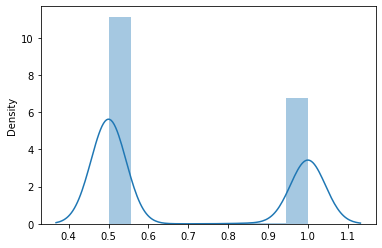

In [520]:
sns.distplot(a)

In [521]:
a[a ==0] = 0.00000000001
eval(a ,G,Ytest)

Reconstruction Step .... Done
Speech SDR = 4.890741914963148
Music SDR = 0.5622547531279469


In [508]:
def eval(D,G_test,Ytest):
  Sources,Masks=Reconstruct(B=D,G=G_test,Ns=10,Nm=10,Yabs=Ytest,p=1)

  print('Reconstruction Step .... Done')
  speech_est = Sources[0]
  music_est = Sources[1]

  _, speech_est =  signal.istft(speech_est,
                      samplerate,
                      window = WINDOW,
                      nperseg=WINDOW_SIZE,
                      noverlap=OVERLAP,
                      nfft = NFFT)

  _, music_est =  signal.istft(music_est,
                      samplerate,
                      window = WINDOW,
                      nperseg=WINDOW_SIZE,
                      noverlap=OVERLAP,
                      nfft = NFFT)

  sdr_speech = SDR(s_est=speech_est,s=test_s)
  sdr_music = SDR(s_est=music_est, s=test_m)
  np.savetxt("speech_nmf",speech_est)
  print(f'Speech SDR = {sdr_speech}')
  print(f'Music SDR = {sdr_music}')

In [506]:
np.savetxt("speech_original",test_s)

In [509]:
eval(np.transpose(B) ,G,Ytest)

Reconstruction Step .... Done
Speech SDR = 3.616840374783834
Music SDR = 0.4735498443366221
